In [1]:
import numpy as np
import pandas as pd
import os, glob, gc
import torch
from torch.utils.data import DataLoader, Dataset
import h5py
import pyarrow.parquet as pq
from tqdm import tqdm
import seaborn as sns
import itertools
from astropy.stats import sigma_clip

## Inspecting signal from each sensor

AIRS sensor

In [ ]:
with h5py.File(dataset_dir + "/train_joint.h5") as data_file:

    print("Keys :", list(data_file.keys()))

    airs_clean_train = data_file["AIRS"]
    fgs_clean_train = data_file["FGS"]
    
    trial = airs_clean_train[0,2,:,:].T
    plt.imshow(airs_clean_train[0,2,:,:], aspect = "auto")

    check = np.where(trial == 0.0)
    print(check) 

#### output : 

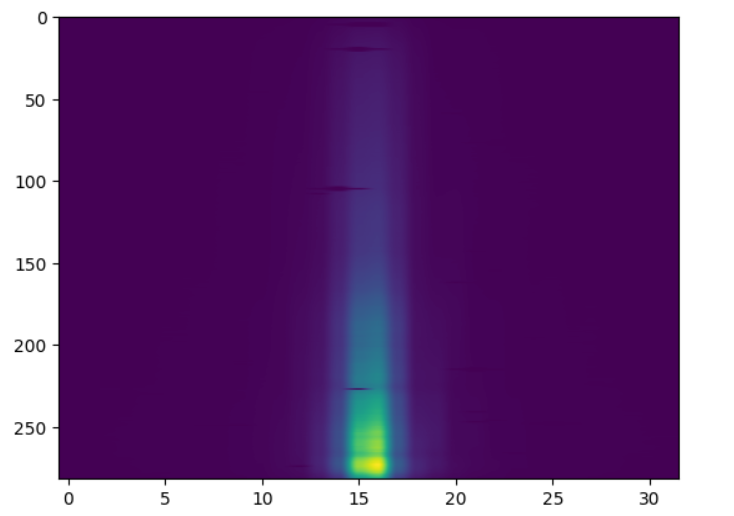

FGS sensor

In [ ]:
with h5py.File(dataset_dir + "/train_joint.h5") as data_file:

    print("Keys :", list(data_file.keys()))

    airs_clean_train = data_file["AIRS"]
    fgs_clean_train = data_file["FGS"]
    print(airs_clean_train.shape)
    
    trial = fgs_clean_train[0,2,:,:].T

    plt.imshow(trial, aspect = "auto")

Output

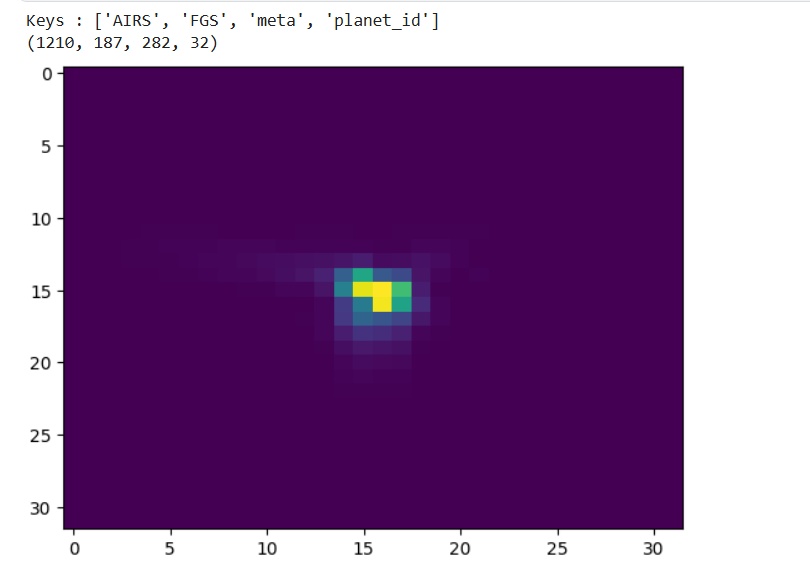

### Foreground processing

In [2]:
def subtract_foreground(signal, sensor):
    if sensor == "AIRS":
        signal_bg = np.nanmean(
            np.concatenate([signal[:,:,:,0:8], signal[:,:, :, 24:32]], axis = -1), axis = -1
        )   # concatenating the background pixels and taking mean over the last axis (collapsing the spatial axis)
            # shape (planet, time, wavelength)
        
        signal_bg[np.isnan(signal_bg)] = 0.0
        signal = signal[:,:,:,8:24]   # indices for point spread function
        
        signal = np.nanmean(signal, axis = -1)   # mean over spatial axis (point spread function), collapsing the spatial axis
        # shape (planet, time , wavelength)
        
        # signal_bg = np.nanmean(signal_bg, axis = 1, keepdims = True) # mean over all the time stamps 
        # collapsed the time axis 
    
        # keeping it time varying background
        signal -= signal_bg  # shape (planet, time, wavelength)

    elif sensor == "FGS":
        signal = signal[:,:,10:22,10:22]  # cropping the point spread function patch
        signal = signal.reshape(signal.shape[0], signal.shape[1], -1)  # (planet, time, 144)        

    return signal    # FGS1 --> (planet, time, pixels), AIRS --> (planet, time, wavelength spectrum)